In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16

from sklearn.metrics import accuracy_score, confusion_matrix

from PIL import Image 
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
LANDSCAPE_TYPE = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'

# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('./ucse-ia-2024-tp-2-clasificacion-de-imagenes/train')
TEST_DIR = Path('./ucse-ia-2024-tp-2-clasificacion-de-imagenes/test')

SIZE = 100

In [3]:
images_reader = ImageDataGenerator(
    rescale=1/255,  # Normaliza los píxeles a valores entre 0 y 1
    rotation_range=20,  # Rotar imágenes aleatoriamente entre 0 y 20 grados
    width_shift_range=0.2,  # Desplazar horizontalmente hasta el 20% del ancho
    height_shift_range=0.2,  # Desplazar verticalmente hasta el 20% de la altura
    shear_range=0.2,  # Cortar (shear) imágenes aleatoriamente
    zoom_range=0.2,  # Ampliar imágenes aleatoriamente
    horizontal_flip=True,  # Voltear imágenes horizontalmente
    fill_mode='nearest',  # Estrategia para rellenar nuevos píxeles
    brightness_range=(0.5, 1.5),  # Cambiar brillo aleatoriamente
    validation_split=0.4  # Porcentaje para la validación (40%)
)

READ_PARAMS = dict(
    class_mode="categorical",
    classes=LANDSCAPE_TYPE, # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE), # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    batch_size=32, # Tamaño del lote
)

In [4]:
# Generador para entrenamiento (60%)
train = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='training',
    **READ_PARAMS
)

# Generador para validación (40%)
validation = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    **READ_PARAMS
)

Found 8424 images belonging to 6 classes.
Found 5610 images belonging to 6 classes.


In [5]:
def sample_images_train(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(LANDSCAPE_TYPE[np.argmax(labels[i])])
        plt.axis("off")

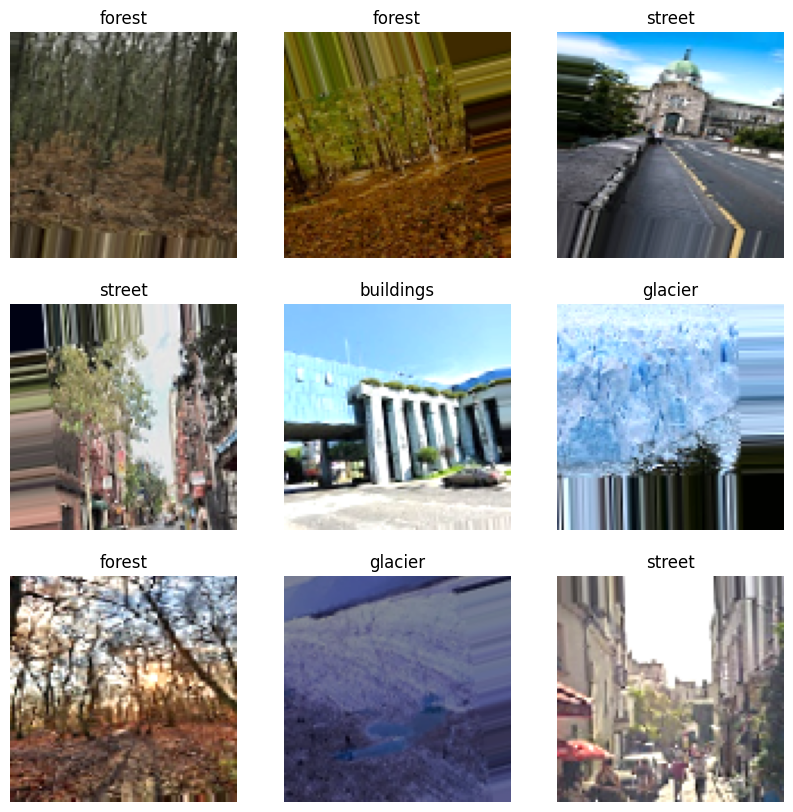

In [6]:
sample_images_train(train)

# 1 Análisis exploratorio sobre el conjunto de datos

## 1.1 Volumetría de los datos

In [7]:
def count_images_by_category(dataset_dir):
    categories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    category_counts = {}

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        image_files = [f for f in os.listdir(category_path) if f.endswith(('jpg', 'jpeg', 'png'))]
        category_counts[category] = len(image_files)

    total_images = sum(category_counts.values())

    return category_counts, total_images

# Obtener la volumetría de los datos
category_counts, total_images = count_images_by_category(TRAIN_DIR)

print("Volumetría del dataset:")
print(f"Total de imágenes: {total_images}")
for category, count in category_counts.items():
    print(f"{category}: {count} imágenes")

Volumetría del dataset:
Total de imágenes: 14034
forest: 2271 imágenes
buildings: 2191 imágenes
glacier: 2404 imágenes
street: 2382 imágenes
mountain: 2512 imágenes
sea: 2274 imágenes


## 1.2 Estructura y tipo de las imágenes

In [8]:
def get_image_dimensions(dataset_dir):
    image_dimensions = []
    image_formats = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                image_dimensions.append(img.size)  # Obtiene el tamaño (ancho, alto)
                image_formats.append(img.format)  # Obtiene el formato de la imagen
    
    return image_dimensions, image_formats

# Obtener la estructura de las imágenes
image_dimensions, image_formats = get_image_dimensions(TRAIN_DIR)

# Muestra algunos ejemplos de dimensiones y formatos
print("Ejemplos de dimensiones de imágenes:")
for i in range(5):
    print(f"Imagen {i+1}: {image_dimensions[i]} (Formato: {image_formats[i]})")


Ejemplos de dimensiones de imágenes:
Imagen 1: (150, 150) (Formato: JPEG)
Imagen 2: (150, 150) (Formato: JPEG)
Imagen 3: (150, 150) (Formato: JPEG)
Imagen 4: (150, 150) (Formato: JPEG)
Imagen 5: (150, 150) (Formato: JPEG)


## 1.3 Distribución de la variable a predecir

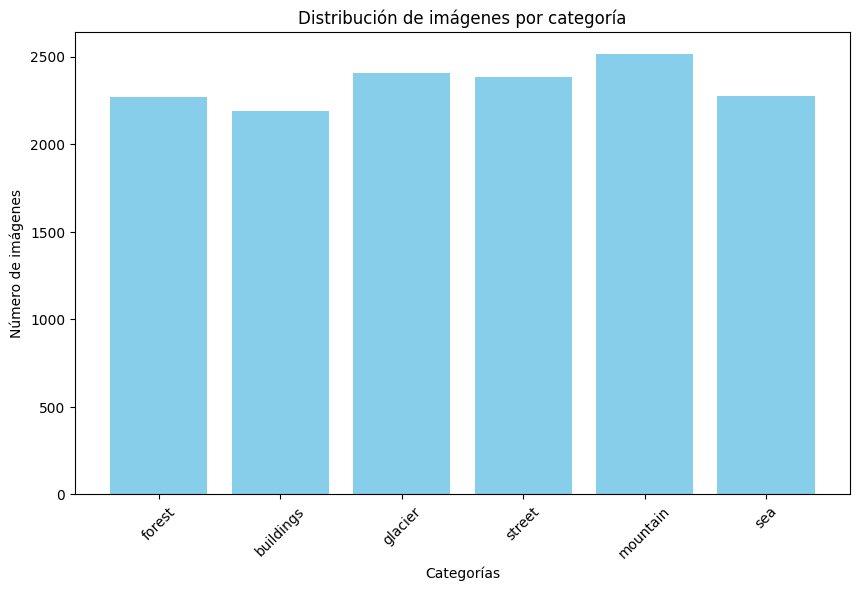

In [9]:
def plot_image_distribution(category_counts):
    categories = list(category_counts.keys())
    counts = list(category_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Categorías')
    plt.ylabel('Número de imágenes')
    plt.title('Distribución de imágenes por categoría')
    plt.xticks(rotation=45)
    plt.show()

# Graficar la distribución de las imágenes por categoría
plot_image_distribution(category_counts)

# 2 Modelado

In [10]:
# UTILS

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

# Función para plotear el historial de entrenamiento
def PlotHistory(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

class MLPBuilder:
    def __init__(
        self, 
        input_shape=(SIZE, SIZE, 3), 
        output_size=len(LANDSCAPE_TYPE),
    ):
        self.input_shape = input_shape  # Ej: (SIZE, SIZE, 3)
        self.output_size = output_size  # Ej: len(LANDSCAPE_TYPE)
        self.model = None
    
    def build_model(self, layers_config, batch_normalization=False):
        """
        Construye un modelo secuencial MLP basado en la configuración proporcionada.

        :param layers_config: Lista de diccionarios con la configuración de cada capa. 
                              Ej: [{'units': 1024, 'activation': 'tanh', 'dropout': 0.25}, {...}]
        """
        self.model = Sequential()
        
        # Primera capa: Flatten (Aplanar las imágenes)
        self.model.add(Flatten(input_shape=self.input_shape))
        
        # Agregar capas ocultas configuradas
        for layer in layers_config:            
            if layer['activation'] == 'leakyrelu':
                self.model.add(Dense(layer['units']))
                self.model.add(LeakyReLU(alpha=0.01))
            else:
                self.model.add(Dense(layer['units'], activation=layer['activation']))

            if batch_normalization:
                self.model.add(BatchNormalization())

            if 'dropout' in layer:
                self.model.add(Dropout(layer['dropout']))
        
        # Capa de salida (softmax para clasificación multiclase)
        self.model.add(Dense(self.output_size, activation='softmax'))

    def compile_model(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        """
        Compila el modelo con el optimizador, la función de pérdida y las métricas indicadas.
        """
        if self.model:
            self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            self.model.summary()
        else:
            raise ValueError("El modelo no está construido. Llama a build_model primero.")
    
    def get_model(self):
        """
        Devuelve el modelo generado.
        """
        return self.model

    def fit_model(self, train=train, validation=validation, epochs=10, batch_size=32, callbacks=[OurCustomCallback()]):
        """
        Entrena el modelo con 10 épocas por default.
        """
        return PlotHistory(self.model.fit(
            train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation,
            callbacks=callbacks,
        ))

## Modelo MLP 1024 - 512 - 256

In [11]:
# Configuración de capas del MLP
layers_config = [
    {'units': 1024, 'activation': 'relu', 'dropout': 0.25},
    {'units': 512, 'activation': 'relu', 'dropout': 0.25},
    {'units': 256, 'activation': 'relu', 'dropout': 0.25}
]

mlp_model_builder = MLPBuilder()
mlp_model_builder.build_model(layers_config)
mlp_model_builder.compile_model()

/Users/vyj/myenv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    30,721,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,378,694 (119.70 MB)

 Trainable params: 31,378,694 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/vyj/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


264/264 ━━━━━━━━━━━━━━━━━━━━ 77s 286ms/step - accuracy: 0.2062 - loss: 6.2400 - val_accuracy: 0.3282 - val_loss: 1.6159
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 77s 288ms/step - accuracy: 0.3069 - loss: 1.6352 - val_accuracy: 0.3902 - val_loss: 1.5462
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 80s 302ms/step - accuracy: 0.3285 - loss: 1.6042 - val_accuracy: 0.4344 - val_loss: 1.4750
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 81s 306ms/step - accuracy: 0.3860 - loss: 1.5546 - val_accuracy: 0.3927 - val_loss: 1.5039
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 82s 306ms/step - accuracy: 0.3698 - loss: 1.5589 - val_accuracy: 0.4702 - val_loss: 1.4226
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 82s 307ms/step - accuracy: 0.3829 - loss: 1.5361 - val_accuracy: 0.4412 - val_loss: 1.4397
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 81s 305ms/step - accuracy: 0.3850 - loss: 1.5241 - val_accuracy: 0.3993 - val_loss: 1.4693
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 81s 306ms/step - accuracy: 0.3939 - loss: 1.5033 - val

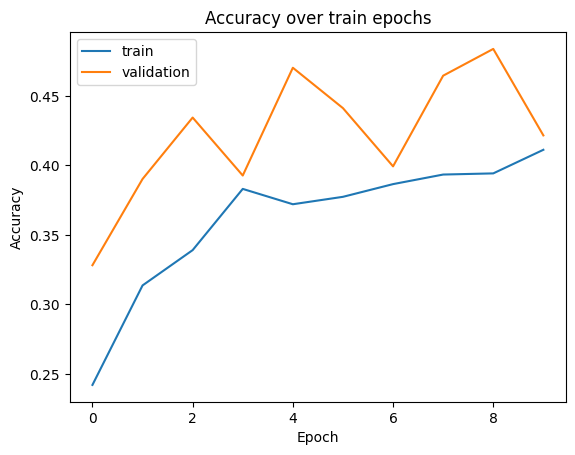

In [12]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()

### Conclusiones

Este primer modelo MLP que probamos no está alcanzando una buena precisión, tanto en el conjunto de entrenamiento como en el de validación. La precisión se mantiene baja (~0.26) y la pérdida es relativamente alta. 

El número de neuronas (1024, 512, 256) podría ser demasiado grande para el problema. Vamos a reducirlas para evitar el sobreajuste, dado que el modelo parece estar teniendo dificultades para generalizar.



Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 82s 308ms/step - accuracy: 0.3935 - loss: 1.5122 - val_accuracy: 0.4513 - val_loss: 1.4324
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 82s 309ms/step - accuracy: 0.4254 - loss: 1.4665 - val_accuracy: 0.4804 - val_loss: 1.3844
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 81s 305ms/step - accuracy: 0.4170 - loss: 1.4819 - val_accuracy: 0.4405 - val_loss: 1.4463
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 81s 303ms/step - accuracy: 0.4026 - loss: 1.4864 - val_accuracy: 0.4865 - val_loss: 1.4070
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 81s 303ms/step - accuracy: 0.4112 - loss: 1.4711 - val_accuracy: 0.4132 - val_loss: 1.5420
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 80s 302ms/step - accuracy: 0.4246 - loss: 1.4741 - val_accuracy: 0.4378 - val_loss: 1.4240
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 81s 304ms/step - accuracy: 0.4279 - loss: 1.4593 - val_accuracy: 0.4845 - val_loss: 1.3610
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 80s 302ms/step - accuracy: 0.4349 - loss: 1

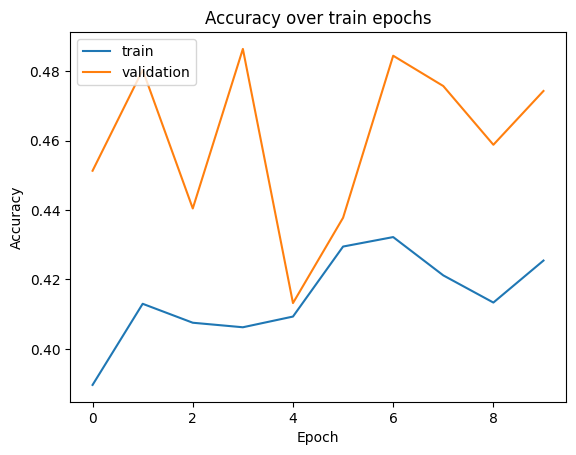

In [13]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()

## Modelo MLP 256 - 128

In [14]:
# Configuración de capas del MLP
layers_config = [
    {'units': 256, 'activation': 'relu', 'dropout': 0.25},
    {'units': 128, 'activation': 'relu', 'dropout': 0.25},
]

mlp_model_builder = MLPBuilder()
mlp_model_builder.build_model(layers_config)
mlp_model_builder.compile_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,713,926 (29.43 MB)

 Trainable params: 7,713,926 (29.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 46s 169ms/step - accuracy: 0.1765 - loss: 4.5860 - val_accuracy: 0.1790 - val_loss: 1.7657
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 169ms/step - accuracy: 0.1806 - loss: 1.7911 - val_accuracy: 0.1791 - val_loss: 1.7909
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 169ms/step - accuracy: 0.1770 - loss: 1.7906 - val_accuracy: 0.1791 - val_loss: 1.7908
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 167ms/step - accuracy: 0.1809 - loss: 1.7912 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 168ms/step - accuracy: 0.1747 - loss: 1.7926 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 168ms/step - accuracy: 0.1836 - loss: 1.7908 - val_accuracy: 0.1791 - val_loss: 1.7907
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 169ms/step - accuracy: 0.1736 - loss: 1.7918 - val_accuracy: 0.1790 - val_loss: 1.7908
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 168ms/step - accuracy: 0.1841 - loss: 1

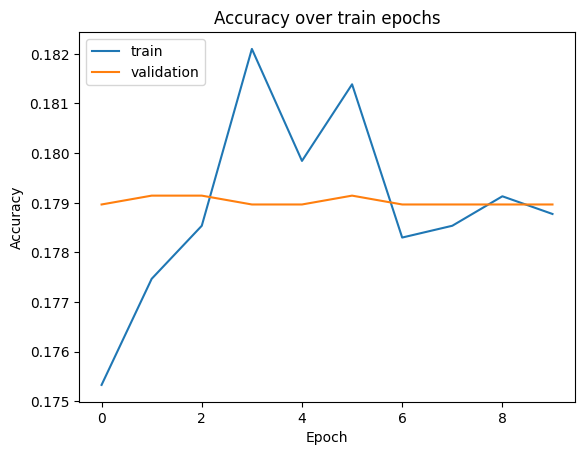

In [15]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()

### Variante del modelo MLP 256 - 128 con menos porcentaje de dropout

In [16]:
# Configuración de capas del MLP
layers_config = [
    {'units': 256, 'activation': 'relu', 'dropout': 0.10},
    {'units': 128, 'activation': 'relu', 'dropout': 0.10},
]

mlp_model_builder = MLPBuilder()
mlp_model_builder.build_model(layers_config)
mlp_model_builder.compile_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,713,926 (29.43 MB)

 Trainable params: 7,713,926 (29.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 166ms/step - accuracy: 0.2502 - loss: 5.2927 - val_accuracy: 0.4016 - val_loss: 1.5602
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step - accuracy: 0.3385 - loss: 1.5740 - val_accuracy: 0.3529 - val_loss: 1.5882
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - accuracy: 0.3321 - loss: 1.5703 - val_accuracy: 0.3071 - val_loss: 1.5319
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - accuracy: 0.3545 - loss: 1.5396 - val_accuracy: 0.4205 - val_loss: 1.4603
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 163ms/step - accuracy: 0.3697 - loss: 1.5194 - val_accuracy: 0.3993 - val_loss: 1.4873
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step - accuracy: 0.3744 - loss: 1.5126 - val_accuracy: 0.3973 - val_loss: 1.4180
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 166ms/step - accuracy: 0.3806 - loss: 1.4767 - val_accuracy: 0.4068 - val_loss: 1.4141
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - accuracy: 0.3950 - loss: 1

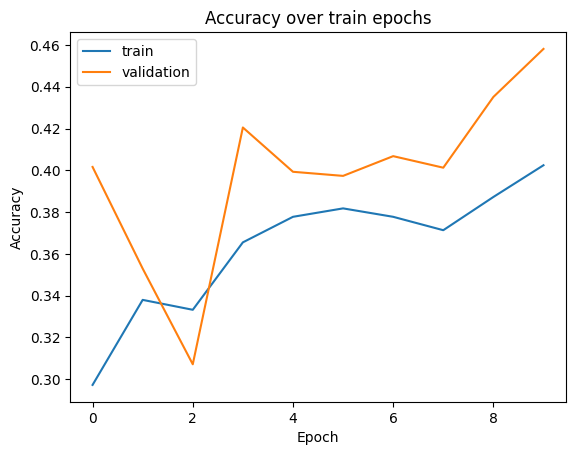

In [17]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()

## Modelo MLP 128 - 64

In [18]:
# Nueva Configuración de Capas del MLP
layers_config = [
    {'units': 128, 'activation': 'tanh', 'dropout': 0.15},
    {'units': 64, 'activation': 'tanh', 'dropout': 0.15},
]

mlp_model_builder = MLPBuilder()
mlp_model_builder.build_model(layers_config)
mlp_model_builder.compile_model()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,840,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,848,774 (14.68 MB)

 Trainable params: 3,848,774 (14.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.1810 - loss: 2.0261 - val_accuracy: 0.2415 - val_loss: 1.7675
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - accuracy: 0.2062 - loss: 1.8332 - val_accuracy: 0.2260 - val_loss: 1.7466
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 46s 172ms/step - accuracy: 0.1968 - loss: 1.8379 - val_accuracy: 0.1636 - val_loss: 1.7935
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.1718 - loss: 1.8536 - val_accuracy: 0.1713 - val_loss: 1.8002
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 159ms/step - accuracy: 0.1910 - loss: 1.8300 - val_accuracy: 0.1793 - val_loss: 1.7904
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.1746 - loss: 1.8300 - val_accuracy: 0.1756 - val_loss: 1.7916
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 42s 155ms/step - accuracy: 0.2074 - loss: 1.7908 - val_accuracy: 0.1758 - val_loss: 1.7921
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.2029 - loss: 1

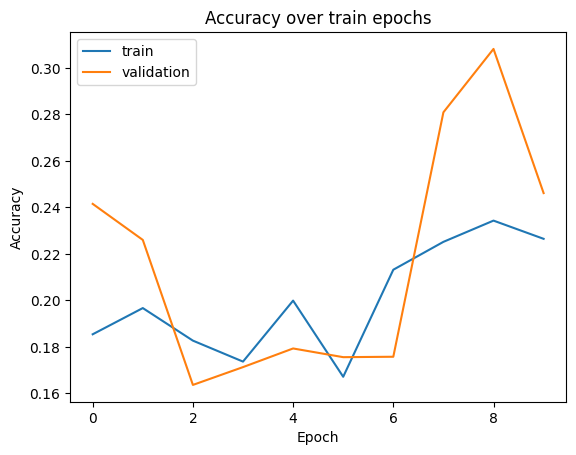

In [19]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()

### Conclusiones

El nuevo modelo simplificado muestra una mejora en la precisión, aunque sigue habiendo espacio para optimizarlo. Actualmente, la precisión en el conjunto de validación se estabiliza entre un 30% y 35%, lo que indica que el modelo aún no está capturando de manera efectiva todas las características del conjunto de datos. Se puede observar que en la época 8 el modelo alcanza su límite de rendimiento, comenzando a presentar signos de sobreajuste.

## Modelo MLP con LeakyReLU y Batch Normalization

In [20]:
layers_config = [
    {'units': 256, 'activation': 'leakyrelu', 'dropout': 0.15},
    {'units': 128, 'activation': 'leakyrelu', 'dropout': 0.15},
]

mlp_model_builder = MLPBuilder()
mlp_model_builder.build_model(layers_config, batch_normalization=True)
mlp_model_builder.compile_model()

/Users/vyj/myenv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,715,462 (29.43 MB)

 Trainable params: 7,714,694 (29.43 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 164ms/step - accuracy: 0.3569 - loss: 1.7239 - val_accuracy: 0.3567 - val_loss: 1.5492
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step - accuracy: 0.4336 - loss: 1.4591 - val_accuracy: 0.4176 - val_loss: 1.4734
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step - accuracy: 0.4499 - loss: 1.4060 - val_accuracy: 0.4633 - val_loss: 1.3597
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - accuracy: 0.4745 - loss: 1.3788 - val_accuracy: 0.4528 - val_loss: 1.3641
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step - accuracy: 0.4826 - loss: 1.3347 - val_accuracy: 0.4922 - val_loss: 1.3095
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - accuracy: 0.4910 - loss: 1.3234 - val_accuracy: 0.4654 - val_loss: 1.3595
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - accuracy: 0.4897 - loss: 1.2904 - val_accuracy: 0.4859 - val_loss: 1.3179
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 45s 167ms/step - accuracy: 0.5085 - loss: 1

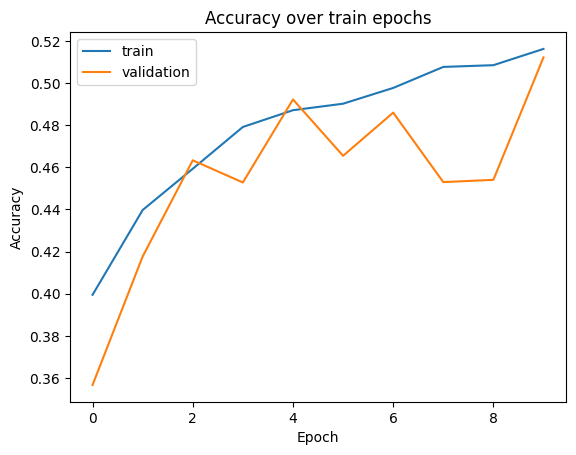

In [21]:
# Entrena el modelo y lo plotea
mlp_model_builder.fit_model()